In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import least_squares
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal

from model.PDV import *
from model.data import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download data

In [2]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('1995-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [3]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [4]:
# spx_data.to_csv('spx_data.csv')
# vix_data.to_csv('vix_data.csv')

In [5]:
spx_data = pd.read_csv('data/spx_data.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('data/vix_data.csv', index_col=0, parse_dates=[0])

In [6]:
data = create_df_from_yf(spx_data, train_start_date, test_start_date, vix_df=vix_data, log_return=True)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607
2018-12-26,0.048403,2.342868e-03,0.3041
2018-12-27,0.008526,7.269658e-05,0.2996
2018-12-28,-0.001242,1.543443e-06,0.2834


In [7]:
window = 100
dataset = VIXDataset(data, window)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fitting

## SGD

In [8]:
# params = torch.tensor([0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5], requires_grad=True)
# optimizer = torch.optim.Adam([params], lr=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

# for epoch in range(100):
#     losses = []
#     for x, y in dataloader:
#         preds = torch_predict(params, x)
#         loss = nn.MSELoss()(preds, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#     epoch_loss = np.mean(losses)
#     print(f'Epoch {epoch} Loss {epoch_loss}')
#     scheduler.step(epoch_loss)

In [9]:
# print(params)
# evaluate(params.detach().numpy(), data, window)

## Least squares

In [10]:
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
# initial_x = [0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5]
initial_x = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
res = least_squares(residual, initial_x, args=(data, window), bounds=(lower_bound, upper_bound), verbose=2, ftol=1e-6)
res.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9944e+00                                    2.02e+02    
       1              2         2.6414e+00      3.35e+00       6.47e+00       3.34e+01    
       2              3         2.2864e+00      3.55e-01       1.93e-02       2.68e+01    
       3              4         2.0963e+00      1.90e-01       8.94e+00       1.55e+01    
       4              7         2.0539e+00      4.24e-02       4.98e-01       2.90e+00    
       5              8         2.0455e+00      8.44e-03       5.68e+00       6.44e+00    
       6              9         2.0413e+00      4.17e-03       6.20e+00       9.60e+00    
       7             10         2.0288e+00      1.25e-02       5.82e+00       5.93e+00    
       8             11         2.0234e+00      5.41e-03       2.00e+00       1.45e+00    
       9             15         2.0228e+00      5.46e-04       1.09e-01       5.54e-01    

array([ 6.49191071e-02, -2.02792399e-02,  5.23609988e+00,  4.46563325e+01,
        1.41075827e+01,  1.37548726e-32,  1.70470047e+01,  1.90411769e-02,
        9.82963474e-01])

In [11]:
evaluate(res.x, data, window)

Mean: 0.0000, Min: -0.1113, Max: 0.1169, MAE: 0.0205, MSE: 0.0007, R^2: 0.8991


# Neural network to model log of ratio residuals (y/y_hat)


In [64]:
nn_window = 20
hidden_size = 64
batch_size = 64
vix_mean = 0.2

In [65]:
residuals, y_hat = residual(res.x, data, window, return_y_hat=True)
vix = residuals + y_hat
ratio_residuals = vix / y_hat
log_ratio_residuals = np.log(ratio_residuals)
log_ratio_residuals.shape

(5942,)

In [66]:
class ResidualNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.window = input_size

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def predict(self, residuals: np.ndarray):
        r_sliding_window = torch.tensor(np.lib.stride_tricks.sliding_window_view(residuals, self.window), dtype=torch.float32)
        return self.forward(r_sliding_window)

class ResidualNNGaussian(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 2*output_size)
        self.window = input_size

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        mu, log_sigma = x.chunk(2, dim=-1)
        return mu, torch.exp(log_sigma)

    def predict(self, residuals: np.ndarray):
        r_sliding_window = torch.tensor(np.lib.stride_tricks.sliding_window_view(residuals, self.window), dtype=torch.float32)
        return self.forward(r_sliding_window)

class ResidualNNv2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.window = input_size
        self.embedding = nn.Linear(1, hidden_size)
        self.pos_encoding = nn.Parameter(torch.randn(1, input_size, hidden_size))
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=hidden_size*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = x.unsqueeze(-1)  # Add feature dimension: (batch_size, seq_len, 1)
        x = self.embedding(x)  # (batch_size, seq_len, hidden_size)
        x = x + self.pos_encoding
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_size)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, hidden_size)
        x = self.fc_out(x[:, -1, :])  # Only use the last output: (batch_size, output_size)
        return x

    def predict(self, residuals: np.ndarray):
        r_sliding_window = torch.tensor(np.lib.stride_tricks.sliding_window_view(residuals, self.window), dtype=torch.float32)
        return self.forward(r_sliding_window)

residual_nn = ResidualNN(input_size=nn_window, hidden_size=hidden_size, output_size=1)
# residual_nn = ResidualNNv2(input_size=nn_window, hidden_size=hidden_size, output_size=1)
# residual_nn = ResidualNNGaussian(input_size=nn_window, hidden_size=hidden_size, output_size=1)
optimizer = torch.optim.Adam(residual_nn.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
residual_nn.to(device)
residual_nn

ResidualNN(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [67]:
r_tensor = torch.tensor(log_ratio_residuals, dtype=torch.float32)
vix_tensor = torch.tensor(vix - vix_mean, dtype=torch.float32)
pred_tensor = torch.tensor(y_hat - vix_mean, dtype=torch.float32)
class ResidualDataset(Dataset):
    def __init__(self, features, residuals, window):
        self.features = features
        self.residuals = residuals
        self.window = window
    def __len__(self):
        return len(self.features) - self.window
    def __getitem__(self, idx):
        x = self.features[idx:idx+self.window].flatten()
        y = self.residuals[idx+self.window]
        return x, y
input_tensor = pred_tensor
# input_tensor = torch.cat((input_tensor, vix_tensor), dim=1)
dataset = ResidualDataset(input_tensor, r_tensor, nn_window)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset) // batch_size

92

In [68]:
# # create validation set
full_data = create_df_from_yf(spx_data, train_start_date, test_end_date, vix_df=vix_data, log_return=True)
preds = predict(*res.x, full_data, window)
df_preds = full_data[window-1:].copy()
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
valid_start_date = test_start_date - pd.Timedelta(days=nn_window)
valid_r_tensor = torch.tensor(df_preds.loc[valid_start_date:test_end_date, 'log_ratio'].values, dtype=torch.float32)
valid_vix_tensor = torch.tensor(df_preds.loc[valid_start_date:test_end_date, 'vix'].values - vix_mean, dtype=torch.float32)
valid_pred_tensor = torch.tensor(df_preds.loc[valid_start_date:test_end_date, 'preds'].values - vix_mean, dtype=torch.float32)
valid_input_tensor = valid_pred_tensor
# valid_input_tensor = torch.cat((valid_pred_tensor, valid_vix_tensor), dim=1)
valid_dataset = ResidualDataset(valid_input_tensor, valid_r_tensor, nn_window)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)

In [69]:
for epoch in range(100):
    losses = []
    current_lr = optimizer.param_groups[0]['lr']
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        preds = residual_nn(x).squeeze()
        if isinstance(residual_nn, ResidualNNGaussian):
            mu, sigma = preds
            dist = Normal(mu, sigma)
            loss = -dist.log_prob(y).mean()
        else:
            loss = nn.MSELoss()(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    epoch_loss = np.mean(losses)
    print(f'Epoch {epoch} Loss {epoch_loss}', end=' / ')
    # validation
    valid_losses = []
    for x, y in valid_dataloader:
        x, y = x.to(device), y.to(device)
        preds = residual_nn(x).squeeze()
        valid_loss = nn.MSELoss()(preds, y)
    print(f'Validation Loss {valid_loss}')
    scheduler.step(valid_loss)
    if scheduler.get_last_lr()[0] != current_lr:
        print(f'Learning rate changed from {current_lr} to {scheduler.get_last_lr()[0]}')
        current_lr = scheduler.get_last_lr()[0]

Epoch 0 Loss 0.016157202823187715 / Validation Loss 0.03179991617798805
Epoch 1 Loss 0.015619558772893363 / Validation Loss 0.03268623724579811
Epoch 2 Loss 0.01564362548011285 / Validation Loss 0.03219267353415489
Epoch 3 Loss 0.01575908608614437 / Validation Loss 0.031538743525743484
Epoch 4 Loss 0.015614361542287052 / Validation Loss 0.032581910490989685
Epoch 5 Loss 0.015654111881890604 / Validation Loss 0.03275148570537567
Epoch 6 Loss 0.015468390618440925 / Validation Loss 0.033689774572849274
Epoch 7 Loss 0.015654686197478285 / Validation Loss 0.03403811529278755
Epoch 8 Loss 0.015441423702624536 / Validation Loss 0.032238706946372986
Epoch 9 Loss 0.015396976983675393 / Validation Loss 0.0307915061712265
Epoch 10 Loss 0.015464208899967132 / Validation Loss 0.034001871943473816
Epoch 11 Loss 0.015338669480976237 / Validation Loss 0.03272730112075806
Epoch 12 Loss 0.015266021673557579 / Validation Loss 0.03306879103183746
Epoch 13 Loss 0.015400456935567882 / Validation Loss 0.0332

# Predicting out of sample

In [70]:
residual_nn.to('cpu')

# Create sliding window of log_ratio values
input = np.lib.stride_tricks.sliding_window_view(df_preds['preds'].values - vix_mean, nn_window)
# input = np.lib.stride_tricks.sliding_window_view(df_preds['log_ratio'].values, nn_window)
input = torch.tensor(input, dtype=torch.float32)

# # Add vix
# vix = np.lib.stride_tricks.sliding_window_view(df_preds['vix'].values, nn_window)
# vix = torch.tensor(vix - vix_mean, dtype=torch.float32)
# input = torch.cat((input, vix), dim=1)

# Convert to tensor



# Use residual_nn to predict
with torch.no_grad():
    nn_preds = residual_nn(input).squeeze().numpy()[:-1]

# Add predictions to df_preds with corresponding datetime index
df_preds.loc[df_preds.index[nn_window:], 'nn_preds'] = np.exp(nn_preds)*df_preds.loc[df_preds.index[nn_window:], 'preds']
df_preds['nn_residuals'] = df_preds['vix'] - df_preds['nn_preds']
df_preds


,r1,r2,vix,preds,residuals,ratio,log_ratio,nn_preds,nn_residuals
1995-05-25,-0.000038,1.425612e-09,0.1163,0.123689,-0.007389,0.940263,-0.061596,NaN,NaN
1995-05-26,-0.009390,8.816395e-05,0.1220,0.137379,-0.015379,0.888052,-0.118725,NaN,NaN
1995-05-30,-0.000134,1.787569e-08,0.1252,0.132332,-0.007132,0.946104,-0.055403,NaN,NaN
1995-05-31,0.018582,3.452829e-04,0.1285,0.133654,-0.005154,0.961441,-0.039322,NaN,NaN
1995-06-01,0.000169,2.844302e-08,0.1221,0.133784,-0.011684,0.912667,-0.091384,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475,0.350728,-0.003228,0.990797,-0.009246,0.354106,-0.006606
2022-05-10,0.002455,6.026444e-06,0.3299,0.338454,-0.008554,0.974726,-0.025598,0.339110,-0.009210
2022-05-11,-0.016600,2.755677e-04,0.3256,0.349547,-0.023947,0.931490,-0.070970,0.352330,-0.026730
2022-05-12,-0.001297,1.681703e-06,0.3177,0.340538,-0.022838,0.932936,-0.069419,0.343342,-0.025642


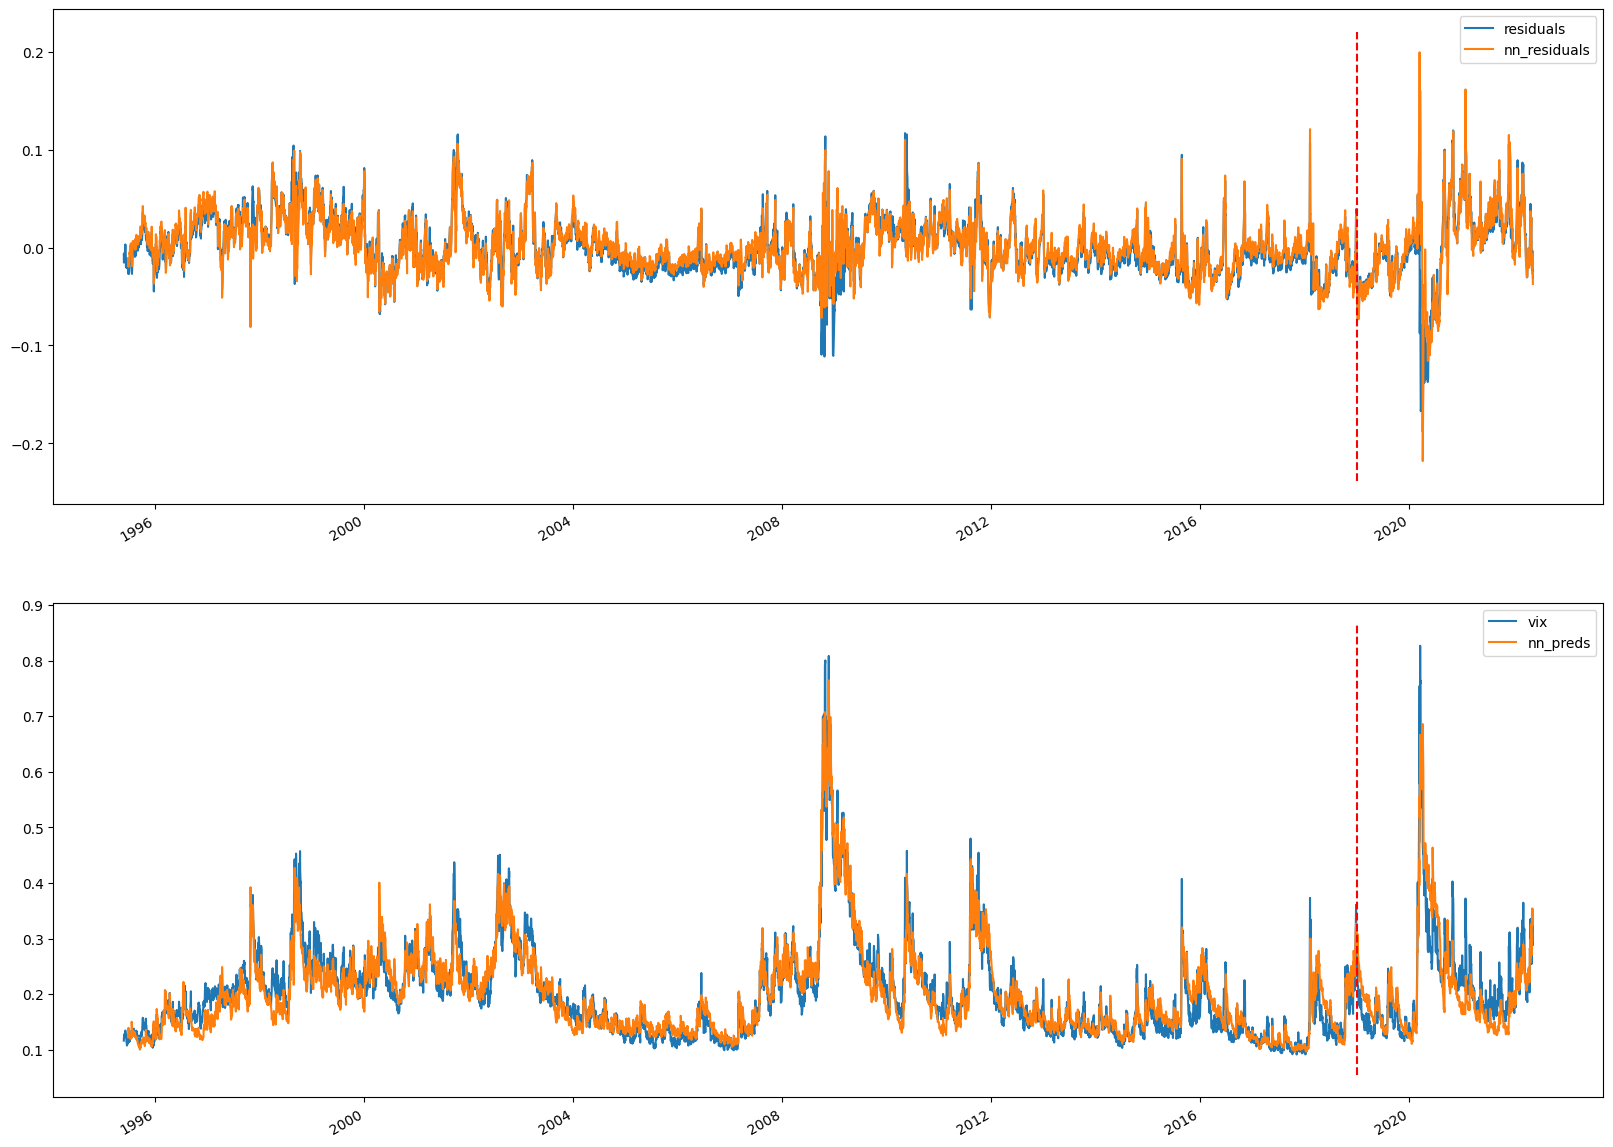

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16))
df_preds[['residuals', 'nn_residuals']].plot(ax=ax[0])
df_preds[['vix', 'nn_preds']].plot(ax=ax[1])
ax[0].vlines(test_start_date, ax[0].get_ylim()[0], ax[0].get_ylim()[-1], linestyles='dashed', colors='red')
ax[1].vlines(test_start_date, ax[1].get_ylim()[0], ax[1].get_ylim()[-1], linestyles='dashed', colors='red')


<Axes: >

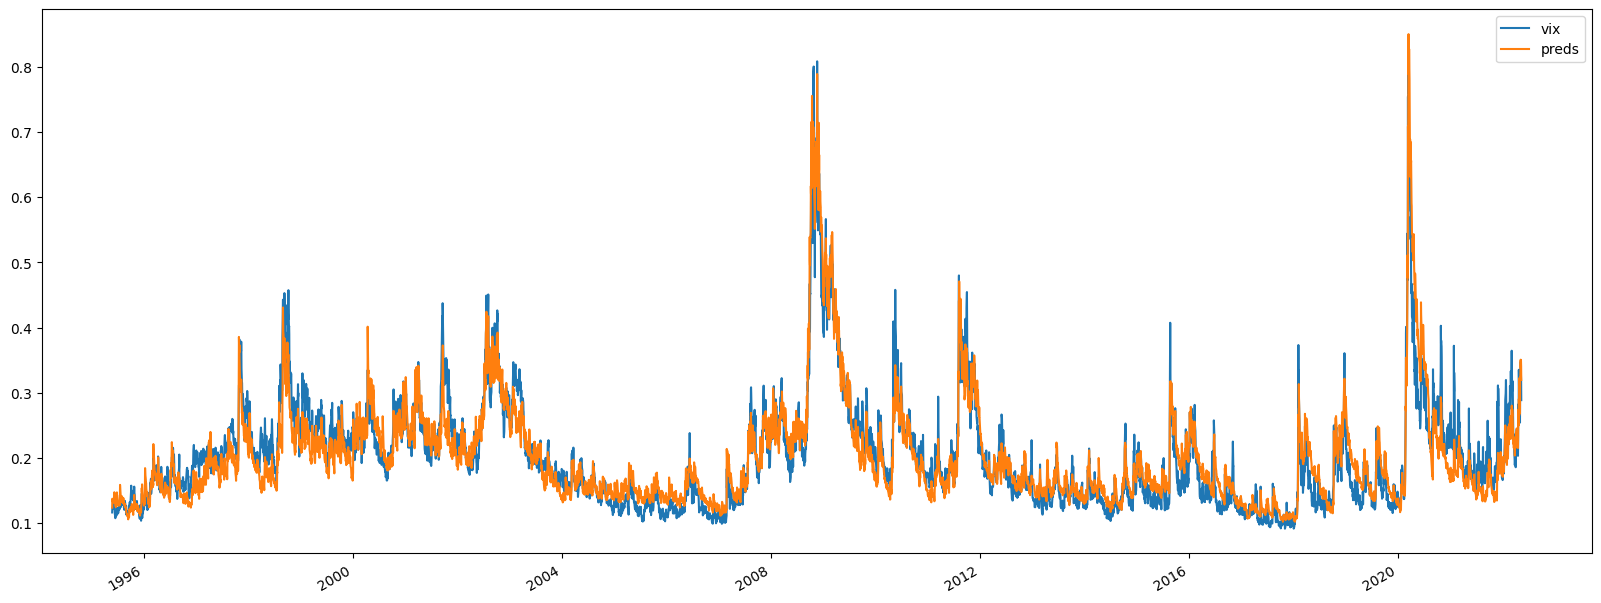

In [72]:
df_preds[['vix', 'preds']].plot(figsize=(20, 8))